<br><br><br>
<div style="text-align: center;"> <h2>
    Dimensionality Reduction for Facial Recognition<br>
    &<br>
    Facilitated Model Implementation </h2>
</div>
<br>
<br> 
<br>

&emsp;&emsp;&emsp;&emsp;**The aim of this project is to implement, evaluate and identify the best dimesnionality reduction technique for a large face images dataset and utilize the derived, reduced data to train a classification algorithm to perform classification on these images, identifying the face images belonding to each target individual in the dataset. Thus, the goal here is twofold: first, to represent the higher dimensional data in a lower dimensional space whilst retaining a reasonable capacity for facial recognition post-transformation, and, second, to facilitate the development and implementation of classification algorithms. As such, three data reduction techniques or models are considered: Principal Component Analysis (PCA), Multi-Dimensional Scaling (MDS), and Non-Negative Matrix Factorization (NMF). With each of these techniques, the necessary measures were taken to identify the optimal number of components or features post-reduction. The models were then evaluated further across each of the following dimensions: i) assessing the model's image reconstruction quality, comparing the face images before and after dimensionality reduction; ii) assessing model generalizability, i.e. the capacity of the obtained model to represent and deal with novel face images, previously unseen during model fitting; and iii) assessing the model's capacity for facial recognition, whether it can match the same faces to their corresponding target individual. As for the classification task, first a baseline classification model was trained and evaluated with the entire data intact, prior to any reduction, and on the basis of this baseline model the effectiveness of these different dimensionality reduction models for representing the original data were evaluated. Further, finally, having identified the dimensionality reduction model that best represented the data, different classification algorithms were developed, optimized, and evaluated to find the best performing one.**
<br>
<br>

&emsp;&emsp;&emsp;&emsp;**The dataset being considered here was taken from Kaggle.com, a popular website for finding and publishing datasets. You can quickly access it on Kaggle by clicking [here](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data). It is a large dataset comprised of more than 13,200 JPEG images of faces of mostly famous personas and popular figures gathered from the internet. Most individuals featured have at least two distinct photos of them. Each picture is centered on a single face with each pixel of each channel encoded by a float in range 0.0-1.0 which represent RBG color. Further, each face image is labeled with the person's name which enables the classification of faces and facial recognition or identification.** 
<br>

**Here is a sample of the faces featured in the data:**
<br>

<img src="faces sample.png" alt="ongoing projects/faces sample.png" width="800" height="600"/>

<br>
<br>

**Overall, this project is broken down into four parts: <br>
&emsp; 1) Reading and Inspecting the Data <br>
&emsp; 2) Data Preprocessing <br>
&emsp; 3) Dimensionality Reduction <br>
&emsp; 4) Classification** <br>

<br>


**Installing and Importing Python Modules**

In [59]:
#Instal the Python packages necessary for the task
!pip install numpy 
!pip install pandas 
!pip install matplotlib 
!pip install seaborn 
!pip install scikit-learn
!pip install imbalanced-learn
!pip install kaggle


In [60]:
#Import the modules for use 
import os
import shutil
import errno
import tarfile 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, NMF
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from kaggle.api.kaggle_api_extended import KaggleApi

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

**Defining custom functions for later evaluations**

In [61]:
#Define function to copy downloaded files from source to correct directory
def copy_files(src, dest):
    try:
        shutil.copytree(src, dest)
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

#Define custom function to plot the amount of explained variance by PCA model
def plot_PCA_explained_variance(pca):
    #This function graphs the accumulated explained variance ratio for a fitted PCA object.
    acc_variance = [*np.cumsum(pca.explained_variance_ratio_)]
    fig, ax = plt.subplots(1, figsize=(15,4))
    ax.stackplot(range(pca.n_components_), acc_variance)
    ax.scatter(range(pca.n_components_), acc_variance, color='black', s=10)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, pca.n_components_+1)
    ax.tick_params(axis='both')
    ax.set_xlabel('N Components', fontsize=11)
    ax.set_ylabel('Accumulated explained variance', fontsize=11)
    plt.tight_layout()

#Define custom function to plot the confusion matrix using a heatmap
def plot_cm(cm, names):
    plt.figure(figsize=(10,7))
    hmap = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=names, yticklabels=names)
    hmap.set_xlabel('Predicted Value', fontsize=13)
    hmap.set_ylabel('Truth Value', fontsize=13)
    plt.tight_layout()

#Define custom functions to compute and report classification error scores
def error_scores(ytest, ypred):
    error_metrics = {
        'Accuracy': accuracy_score(ytest, ypred),
        'Recall': recall_score(ytest, ypred, average='weighted'),
        'Precision': precision_score(ytest, ypred, average='weighted'),
        'F1 score': f1_score(ytest, ypred, average='weighted')
        }

    return pd.DataFrame(error_metrics, index=['Error score']).apply(lambda x:round(x,2)).T

#Define custom function to compute error and return results in dictionary form
def error_scores_dict(ytest, ypred, model):
    #create empty dict for storing results 
    error_dict = {
        'Model': model, 
        'Accuracy': round(accuracy_score(ytest,ypred),2),
        'Precision': round(precision_score(ytest,ypred, average='weighted'),2),
        'Recall': round(recall_score(ytest,ypred, average='weighted'),2),
        'F1 Score': round(f1_score(ytest,ypred, average='weighted'),2)
    }
    
    return error_dict

#Define function to evaluate the image reconstruction quality of a given dim reduction model 
def evaluate_reconstruction(X, estimator, face_indx):
    '''This function evaluates the reconstruction of a given image by index'''
   
    #get face image by index 
    X_face = X[face_indx]
    #get the PCA approximated image 
    X_trans = estimator.transform(X_face.reshape(1,-1))
    X_inv = estimator.inverse_transform(X_trans)

    #plot original image 
    plt.figure(figsize=(10,4))
    plt.subplots_adjust(top=.8)
    plt.subplot(1,2,1)
    plt.imshow(X_face.reshape(h, w), cmap=plt.cm.gray)  
    plt.title("Original Image")
    plt.axis('off')

    #plot image with PCA
    plt.subplot(1,2,2)
    plt.imshow(X_inv.reshape(h,w), cmap='gray')
    plt.title("Approximated Image")
    plt.axis('off')
    plt.show()
    print('\n\n_____________________________________________________________________________________________\n\n')

#Define function to compare images from the train and test sets
def plot_TrainVsTest(X_train, X_test, h, w, train_indx, test_indx, N_imgs):
    random_indx = np.random.randint(0, len(train_indx), N_imgs)
    for train_sample, test_sample in zip(train_indx[random_indx], test_indx[random_indx]):
        #plot figure
        plt.figure(figsize=(9,4.2))
        plt.subplots_adjust(top=.75)
        plt.suptitle(f'True Target: {names[y_train[train_sample]]}\nObtained Target: {names[y_test[test_sample]]}\n\n\n\n', fontsize=11)
        #plot image from training set
        plt.subplot(1,2,1)
        plt.imshow(X_train[train_sample].reshape(h,w), cmap='gray')
        plt.title(f'Train sample {train_sample}')
        plt.axis('off')

        #plot image from testing set 
        plt.subplot(1,2,2)
        plt.imshow(X_test[test_sample].reshape(h,w), cmap='gray')
        plt.title(f'Test sample {test_sample}')
        plt.axis('off')
        plt.show()
        print('\n\n___________________________________________________________________________________\n\n')

#Define custom function to specify threshold criteria for measuring image similarity
def get_threshold(dist_similarity, dist_sim_indices, max_cos=0.1, min_cos=0):
    X_train_indx = np.where(np.logical_and( (dist_similarity>min_cos), (dist_similarity<max_cos) ))[0]
    X_test_indx = dist_sim_indices[np.logical_and( (dist_similarity>min_cos), (dist_similarity<max_cos) )]
    return X_train_indx, X_test_indx

#Define function to compare results of multiple models
def visualize_models_results(results):
    print(results)
    print('\n\n')

    #identify data for plotting
    x = np.arange(4)
    LR_res = results.loc['LR']  
    SVC_res = results.loc['SVC']
    KNN_res = results.loc['KNN']

    #set figure characteristics 
    width = 0.2
    plt.figure(figsize=(14,7), dpi=80)
    
    #Plot bars
    bars1 = plt.bar(x-0.2, LR_res, width, alpha=.9)
    bars2 = plt.bar(x, SVC_res, width, alpha=.85)
    bars3 = plt.bar(x+0.2, KNN_res, width, alpha=.75)

    #set labels and ticks 
    plt.title('Evaluation Scores per Classifier', fontsize=15)
    plt.xticks(x, ['Accuracy', 'Recall', 'Precision', 'Fscore'])
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel("Evaluation Metrics", fontsize=13)
    plt.ylabel("Score", fontsize=13)
    plt.legend(["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors"], loc='upper right', borderaxespad=0.)
    
    #Annotate bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0 + 0.02, height+0.01,
                     f'{height:.2f}', ha='center', va='bottom', rotation=45, fontsize=10)
    plt.show()


**Defining a random state for reproducible results**

In [62]:
#specify random seed
rs = 222

**Downloading and Accessing the Dataset**

In [63]:
#Initialize the Kaggle API to access kaggle
api = KaggleApi()
api.authenticate()

#specifying the kaggle dataset identifier 
kaggle_dataset = 'atulanandjha/lfwpeople'

#specifying the path to save the data to
mypath = 'LFW people dataset' 

#Download dataset
api.dataset_download_files(kaggle_dataset, path=mypath, unzip=True)

#Extract the data from tgz file
tgz_filepath = os.path.join(mypath, 'lfw-funneled.tgz')
with tarfile.open(tgz_filepath,"r:gz") as tar:
    tar.extractall(path=mypath)
os.remove(tgz_filepath)

#Copying files to lfw home for reading 
lfw_home = 'LFW people dataset/lfw_home'
copy_files(mypath, lfw_home)


## Part One: Reading and Inspecting the Data


**Loading the downloaded data**

In [64]:
#fetch face images for targets with at least 35 face images featuring them
lfw_dataset = fetch_lfw_people(data_home=mypath, 
                               min_faces_per_person=35,  #to fetch only target individuals with at least 35 face images featuring them
                               resize=1, 
                               download_if_missing=False)



**Inspecting the data**

In [65]:
#report images shape
n_samples, h, w = lfw_dataset.images.shape
print('Number of face samples in the dataset:', n_samples)
print('Number of rows in the dataset:', h)
print('Number of coloumns in the dataset:', w)
print(f'Therefore we have {n_samples} face samples, each being {h} x {w} pixels')


Number of face samples in the dataset: 2053
Number of rows in the dataset: 125
Number of coloumns in the dataset: 94
Therefore we have 2053 face samples, each being 125 x 94 pixels


In [66]:
#Report number of unique targets
n_classes, names = len(lfw_dataset.target_names), lfw_dataset.target_names
print('Number of unique individuals in the data:', n_classes)


Number of unique individuals in the data: 24


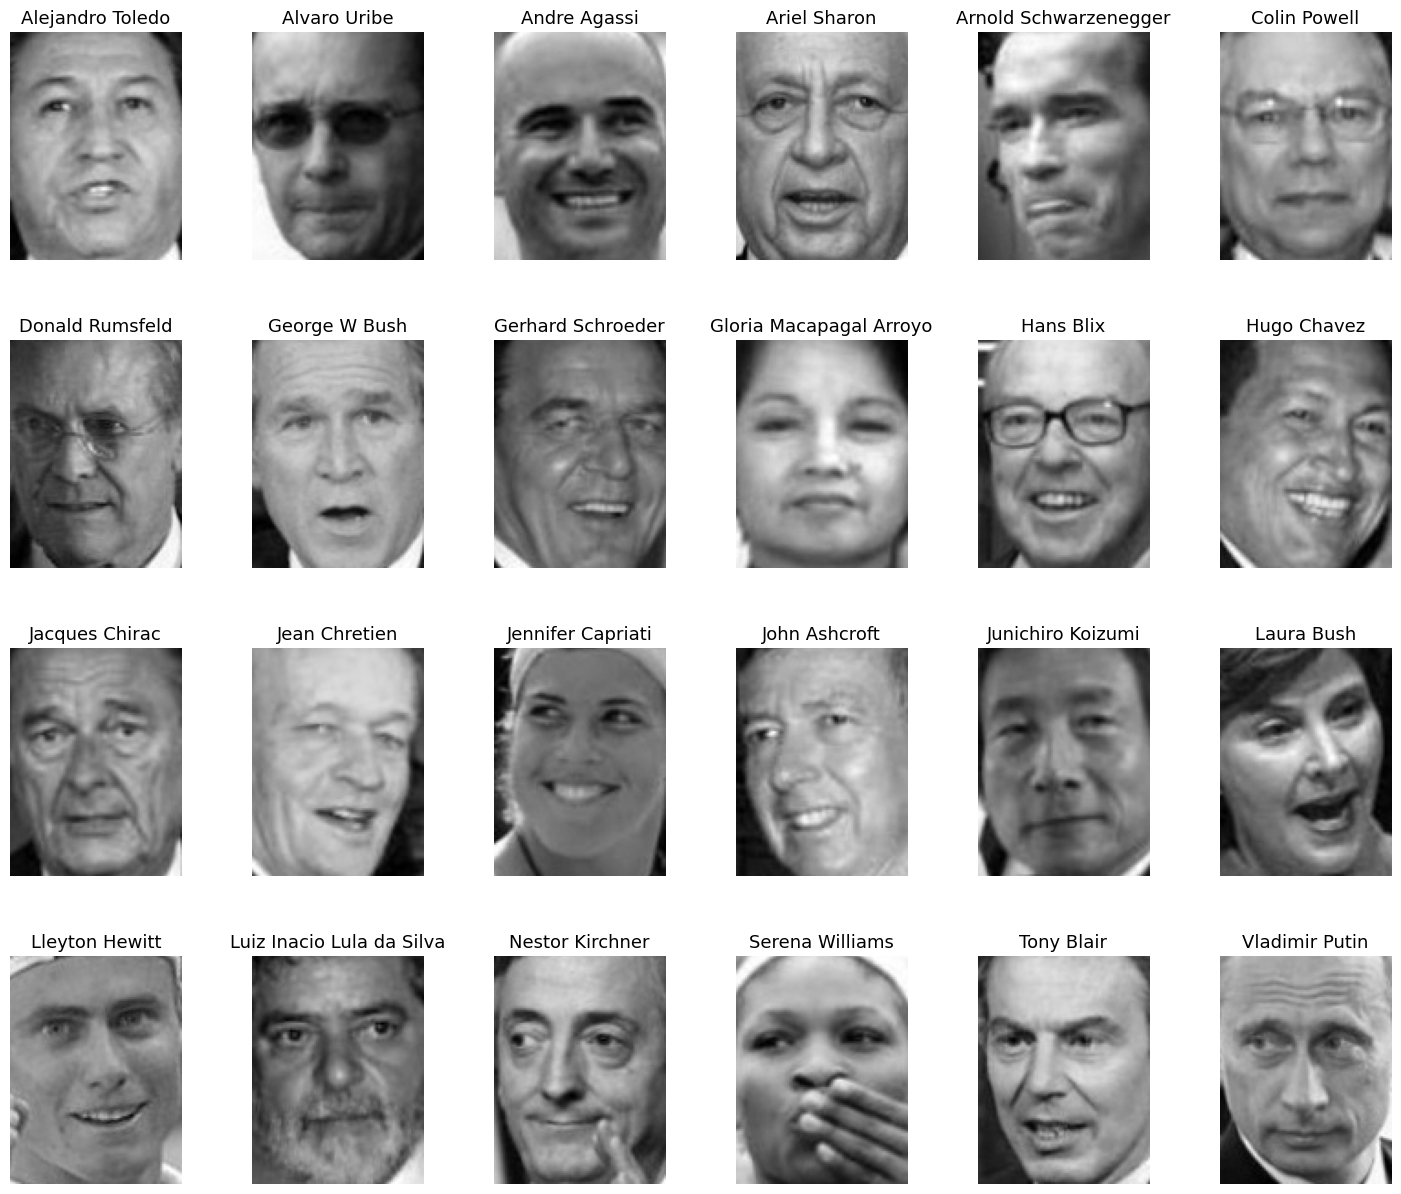

In [67]:
#Viewing the target individuals in the data 
n_row,n_col = 4,6    #specify number of columns and rows
plt.figure(figsize=(2.4 * n_col , 3.2 * n_row))   #create and set figure characteristics 
plt.subplots_adjust(bottom=0, top=.90, left=.01, right=.99, hspace=.35) #set subplots characteristics
for i,face in enumerate(np.unique(lfw_dataset.target)):   
    face_idx = np.argmax(lfw_dataset.target == face)   #get face unique identifier index
    plt.subplot(n_row, n_col, i + 1)   #set subplot position
    plt.imshow(lfw_dataset.data[face_idx].reshape(h, w), cmap=plt.cm.gray)   #plot face in given subplot
    plt.title(names[face], size=13)  #set image title (person's name)
    plt.axis('off')
plt.show()


Here we can see in the figure above 24 different individuals that make up our dataset. Now I'll identify the predictors and target and perform data splitting to obtain a training and testing set before proceeding to implement and test different models for image processing and facial recognition..


## Part Two: Data Preprocessing
<br>

**In this section, I will perform the necessary data preprocessing procedures to make the data ready for model development and evaluation. First, I will select the predictors and target variable; examine the class distribution and deal with any class imbalances; split the data into training and testing sets; and finally perform feature scaling to standardize the data**
<br>
>


### Data Selection

In [68]:
#Identifying the predictors and target variable 
X = lfw_dataset.data
y = lfw_dataset.target


**Examining Data Shape**

In [69]:
#obtain and report shape of the raw data 
shape = X.shape 
print('Number of coloumns:', shape[1])
print('Number of rows:', shape[0])


Number of coloumns: 11750
Number of rows: 2053


We can see here that we have a huge number of features representing the images, totaling 11,750 features! Hence, the need for dimensionality reduction, as we'll see shortly. Each feature here describes the grayscale value of an image's pixel. <br>
<br>


**Examining Class Distribution**

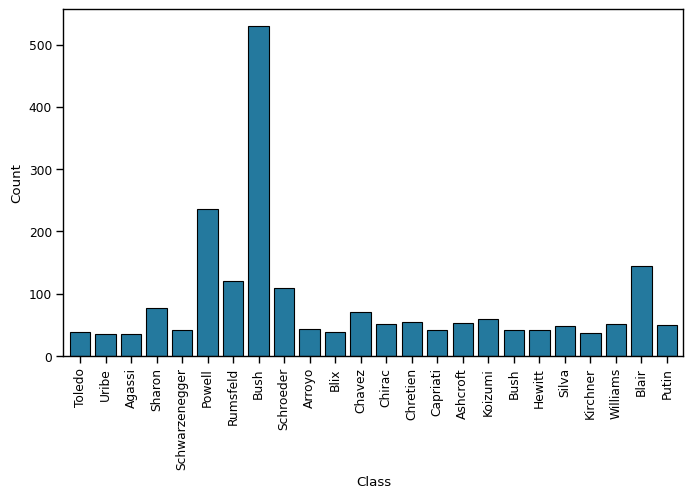

In [70]:
#plot and examine the class distribution in the target variable
sns.set_context('paper')
class_freq = pd.Series(y).value_counts().sort_index()
ax = class_freq.plot(kind='bar', figsize=(8,4.5), color='#24799e', 
                width=.8, linewidth=.8, edgecolor='k', rot=90,
                xlabel='Class', ylabel='Count')
ax.set_xticklabels([name.split(' ')[-1] for name in names])
plt.show()


We can see that our classes are unequal, with targets having more images than others. For instance, class 7 (i.e. George W. Bush) has more than 500 images whilst class 1 (i.e. Alvaro Uribe) has less than 50 images. Thus, we will need to balance the classes first before moving on to model development and evaluation. <br>
<br>

### Data Splitting

In [71]:
#Performing stratified data splitting to obtain a training and testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=rs)


### Dealing with Imbalanced Classes: Resampling

Now as as shown earlier, the classes in the dataset are very imbalanced with some individuals (e.g. George Bush) making up the majority of cases in the dataset, which would likely affect our model performances and classification going forward. Thus, the task here would be to try to balance the classes in the dataset before proceeding. As such, given the nature of our data, particularly that we're dealing with the face images of particular individuals, and also given the large number of features involves, I will use a mixture of over sampling and under sampling. Particularly, I will set a target of 100 face images per person, use random undersampling to reduce the excess of face images for the majority classes and random oversampling to increase the number of face images for the minority classes. As such, in the end, all classes, i.e. individuals in the dataset, should have the same number of face images of 100. This will be implemented on the training data in particular.
<br>
<br>

**Resampling**

In [72]:
#Define the target number of samples per class
target_samples = 100


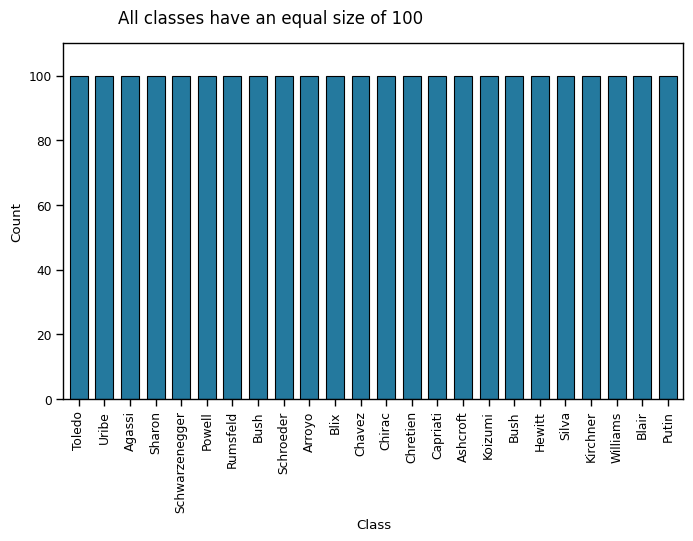

In [73]:
#Define sampling strategies
undersampling_strategy = {key: target_samples for key in range(n_classes) if Counter(y_train)[key] > target_samples}  #undersample if target has less than 100 images
oversampling_strategy = {key: target_samples for key in range(n_classes) if Counter(y_train)[key] < target_samples} #oversample if target has less than 100 images

#Create a pipeline combining over- and undersampling
sampling_pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=rs)),
    ('over', RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=rs))
])

#Resampling the data to get equal sized classes 
X_train, y_train = sampling_pipeline.fit_resample(X_train, y_train)


#We can check the class distribution once again
class_freq = pd.Series(y_train).value_counts().sort_index()
ax = class_freq.plot(kind='bar', figsize=(8,4.5), color='#24799e', 
                width=.7, linewidth=.8, edgecolor='k', rot=90,
                xlabel='Class', ylabel='Count', ylim=(0,np.max(class_freq)+10))
ax.set_xticklabels([name.split(' ')[-1] for name in names])
plt.text(7.5, 115, f'All classes have an equal size of {int(class_freq[0])}', ha='center', va='bottom', fontsize=12)
plt.subplots_adjust(top=.9)
plt.show()


As we can see, now all the classes are balanced: each individual in the dataset has the same number of face images. This should improve our model training  and performance. Next, I will perform feature scaling as multiple dimensionality reduction methods featured here require the data to be scaled first
.

### Feature Scaling
Now I will perform feature standardization to rescale the data. Feature standardization means rescaling the data such that all features would exhibit a normal distribution with a mean score of 0 and standard deviation of 1

In [74]:
#Perform feature standardization 
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)


*Now the data is ready for model development and evaluation...*


## Part Three: Dimensionality Reduction 
<br>
In this section, I will test out different dimensionality reduction models and use them to transform the data and perform classification with the new, reduced data. This should help significantly decrease the number of features to be used in training while also preserving most of the original data's properties which also means that the classification algorithm to be used will be faster and more computationally efficient. As such, I will test three different dimensionality reduction techniques: Principal Component Analysis, Multi-Dimensional Scaling and Non-Negative Matrix Factorization. For each technique, I will train a logistic regression classifier to identify and classify the faces in the data, effectively acting as a facial recognition algorithm. But first, to better understand the classification results, I will develop a baseline classification model on the basis of which to evaluate each of the dimensionality reduction techniques' efficiencies later on.
<br>
<br>

**Baseline Classifaction Model**
<br>
Here I will develop a simple logistic regression model to get a baseline performance based on which to judge the efficiency of  the reduction technique  to be used.

In [75]:
#Create logistic regression object
LR = LogisticRegression(solver='lbfgs', random_state=rs, n_jobs=-1)

#fit the LR classifier with the original data
LR_model = LR.fit(X_train_std, y_train)

#get class peridctions 
y_pred = LR_model.predict(X_test_std)

#Report overall classification error results 
print('Classification error scores (weighted average):')
error_scores(y_test, y_pred)


Classification error scores (weighted average):


Error score
Accuracy          0.71
Recall            0.71
Precision         0.74
F1 score          0.72

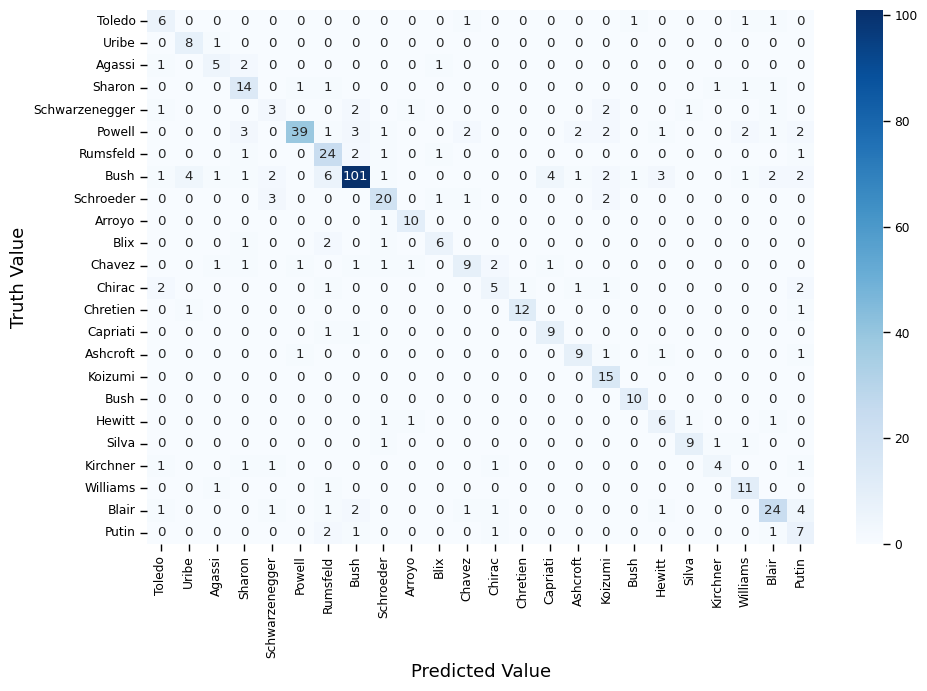

In [76]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, names=[name.split(' ')[-1] for name in names])


As we can see here, the baseline performance of the logistic regression classifier is acceptable, with an accuracy score of 0.71 and an average F1 scores of 0.72. This would allow one of the bases for evaluating the efficiency of the dimensionality reduction techniques to be employed next. The goal here is to reduce the number of features in the data as much as possible whilst retaining a similar or near identical classification performance as observed here. Next, I will begin testing out and evaluating different dimensionality reduction techniques.
<br>
<br>

### Dimensionality Reduction - Model Development and Optimization

#### Model One: Principal Component Analysis

Principal component analysis (PCA) is a popular dimensionality reduction technique whose aim is to reduce the number of features in the data whilst preserving most of the variance or characteristics of the data. PCA achieves this by identifying a set of distinct, orthogonal vectors (i.e. principal components) upon which the original higher-dimensional data are projected and according to which variance is accounted for and explained however represented in a lower-dimensional space, which therefore reduces the number of features in the data while retaining most of its variance. As such, the task here is to identify the right number of components that can accurately represent the data. First, I will create a PCA algorithm that models the data then identify the most optimal number of components that capture the most variance. 
<br>

In [77]:
#Create PCA object
pca = PCA(random_state=rs)
#fit the PCA model 
pca.fit(X_train_std)
#transform the train and test data
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)


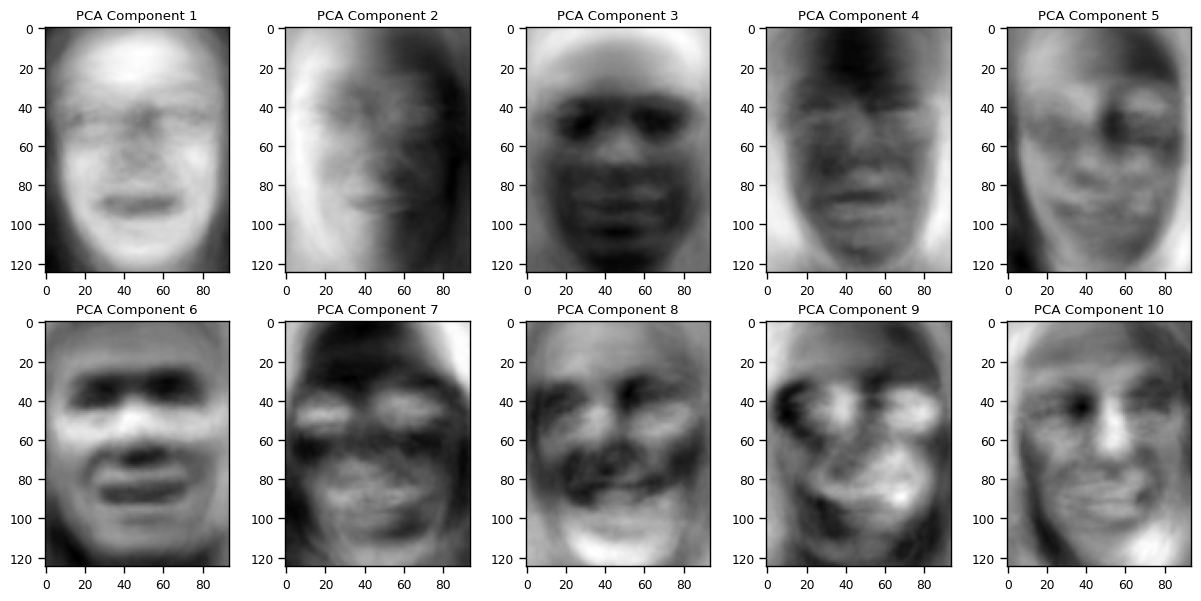

In [78]:
#Visualize first 10 PCA components
fig, axes = plt.subplots(2, 5, figsize=(15,7))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(h, w), cmap='gray')
    ax.set_title(f'PCA Component {i+1}')
plt.show()


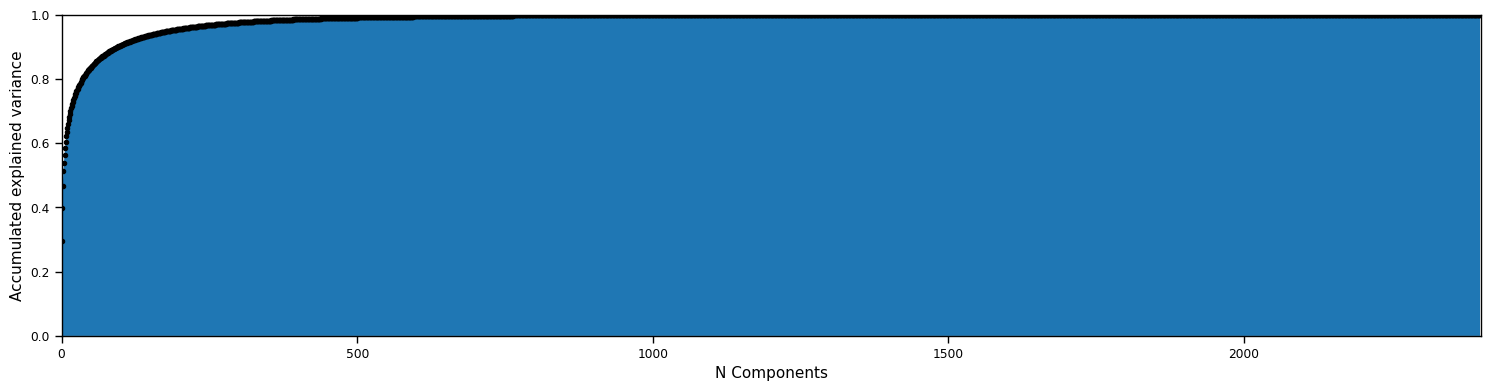

In [79]:
#Plotting the accumulation of explained variance across PCA components
plot_PCA_explained_variance(pca)


We can determine specifically how many dimensions we would need with PCA in order to account for most of the variance in the data, say, 99% variance. To do so, we can compute the accumulative sum on the explained variance per dimension until we reach the number of dimensions that explain 99% of the variance.

In [80]:
#Get number of PCA dimensions necessary for 99% explained variance
acc_variance = np.cumsum(pca.explained_variance_ratio_) <= 0.99
n_components = acc_variance.sum() + 1
n_components   


468

For accounting for 99% of the variance in the data, we have obtained 468 principal components. Thus, I will develop the final PCA model with the obtained number of dimensions before proceeding to test it and utilize it for classification. <br>
<br>


**Final Model Selection**

In [81]:
#Create PCA object with obtained number of components
pca = PCA(n_components=n_components, random_state=rs)
#fit the PCA model 
pca.fit(X_train_std)
#transform the train and test data
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)


**Model Evaluation**

**Testing the Model: Assessing image reconstruction quality** 
<br>
Now we can assess the reconstruction quality of the PCA model by comparing original images in the data to their PCA reconstructed counterpart. To do so, I will define a function that selects 5 image indices at random and use the indices to plot and compare each image and its reconstruction separately

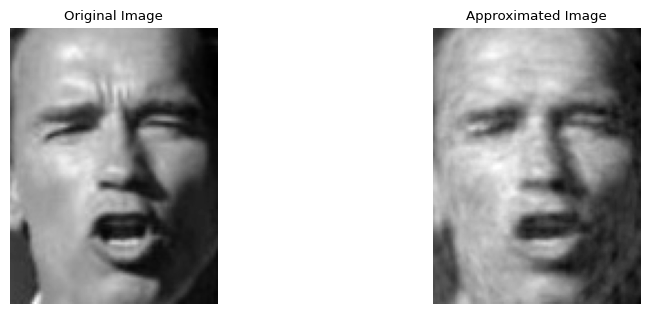



_____________________________________________________________________________________________




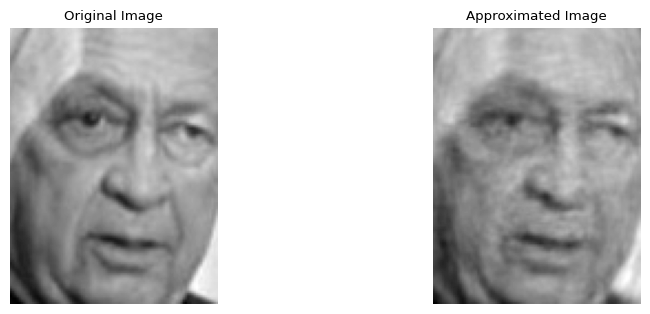



_____________________________________________________________________________________________




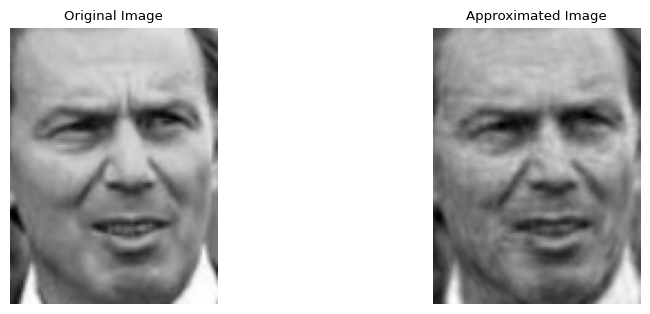



_____________________________________________________________________________________________




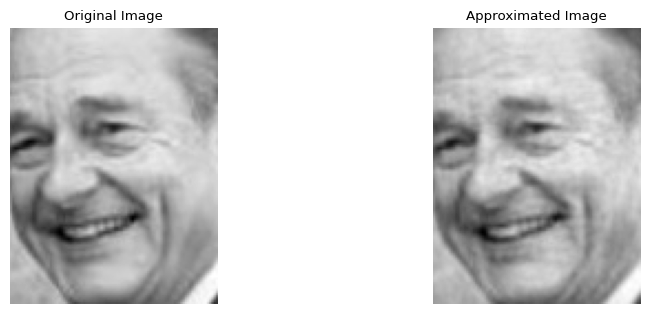



_____________________________________________________________________________________________




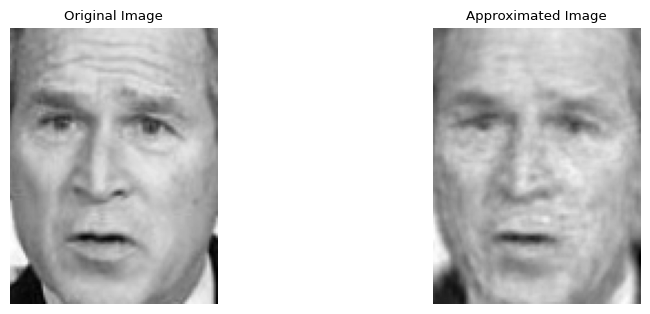



_____________________________________________________________________________________________




In [82]:
#Create lambda function to generate random indices for 5 images 
random_face_generator = lambda X: np.random.randint(0,len(X),5)

#evaluate PCA reconstruction quality of selected images 
for face_indx in random_face_generator(X):
    evaluate_reconstruction(X, pca, face_indx)


As we can see, the approximated images look quite close to the originals. Now we can then use the transformed data and use it to train the logistic regression model to perform classification.

**Testing the Model: Testing Model Generalizability**
<br>
To test the generalizability of the PCA model, I will compute the cosine distance between the training and testing set to determine the similarities detected by the model between them, extract out the most similar cases and examine them in more detail

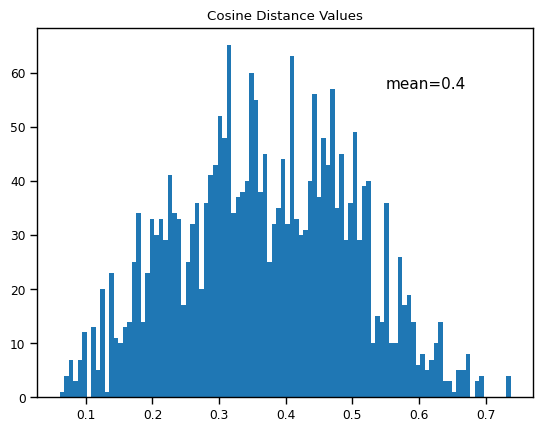

In [83]:
#Get pairwise cosine distances
cos_distances_mtrx = cosine_distances(X_train_pca, X_test_pca)

#Get column indices with most distance similarity and their corresponding cosine distance values (sorted in ascending order)
min_dist_indices = np.argmin(cos_distances_mtrx, axis=1)
min_cosine_dist = np.min(cos_distances_mtrx, axis=1)

#Now visualize the distribution of the distance values using a histogram
plt.hist(min_cosine_dist, bins=100)
plt.title('Cosine Distance Values')
plt.annotate(text=f'mean={np.mean(min_cosine_dist):.1f}', xy=(0.55,57), fontsize=11)
plt.show()


As shown in the above figure, the distribution of cosine pairwise distance similarities ranges from around 0.1 to around 0.6 (mean=0.4), with pairwise distance scores closer to 0 indicating higher similarity and scores closter to 1 indicating less similarity. While this shows an acceptable performance overall, cosine scores are still distributed across a relatively wide range, which might indicate that a lot of similarity cases went undetected or are underestimated. At any rate, the supposed matches obtained are yet to be verified, as I will do next.
<br>

**Testing the Model: Facial Recognition Performance** 
<br>
Now we can control the threshold for cosine distance similarity in order to select only images that are most similar or almost identical, as deemed by the model, and then plot and compare them together. If the similarity turns out to be genuine then we can deem the model good for facial recognition. This can be effectively regarded as a measure of the PCA model's facial recognition performance

In [84]:
#Get indices for images that are most similar with their pairwise distances falling between 0 and 0.1
train_indx, test_indx = get_threshold(min_cosine_dist, min_dist_indices, min_cos=0, max_cos=0.1)

#check the resulting shape
train_indx.shape, test_indx.shape


((29,), (29,))

In the lower range of 0-0.1, we have 29 images. These are likely the most similar or almost identical cases obtained based on the PCA model. We can plot and examine some of these images to verify whether the similarities detected are genuine or only assumed.

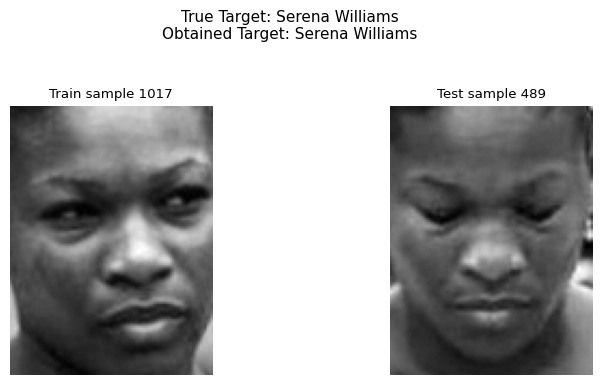



___________________________________________________________________________________




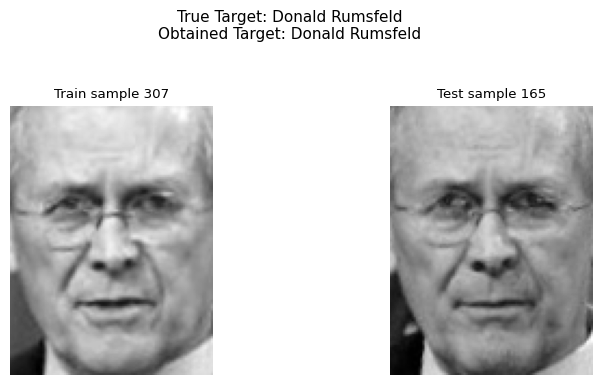



___________________________________________________________________________________




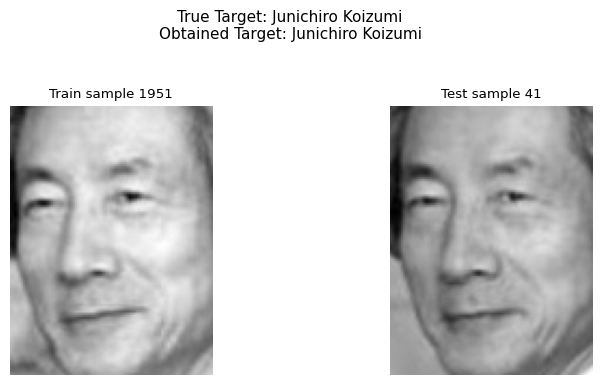



___________________________________________________________________________________




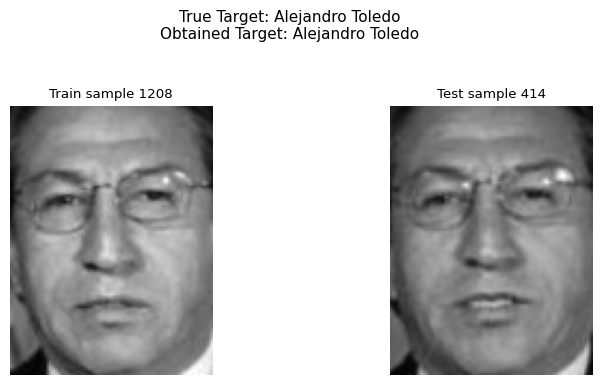



___________________________________________________________________________________




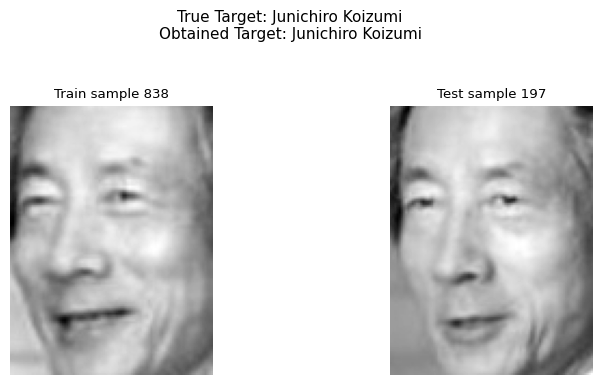



___________________________________________________________________________________




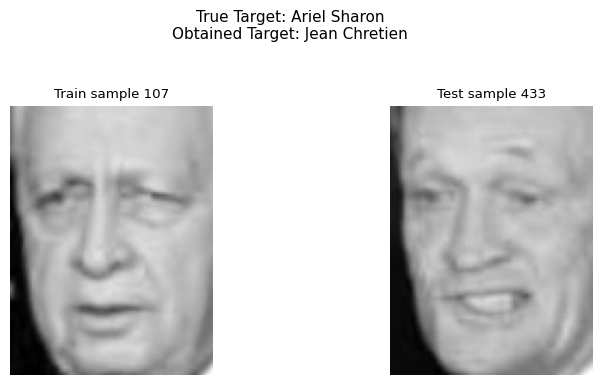



___________________________________________________________________________________




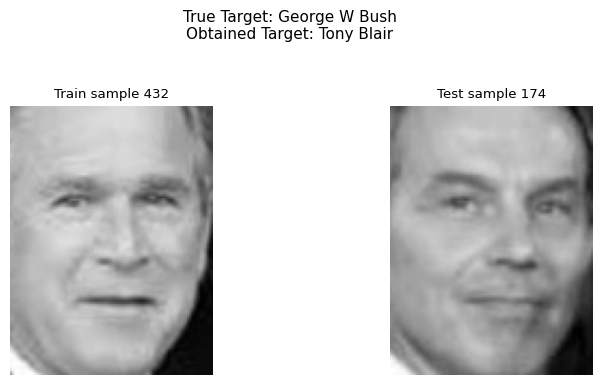



___________________________________________________________________________________




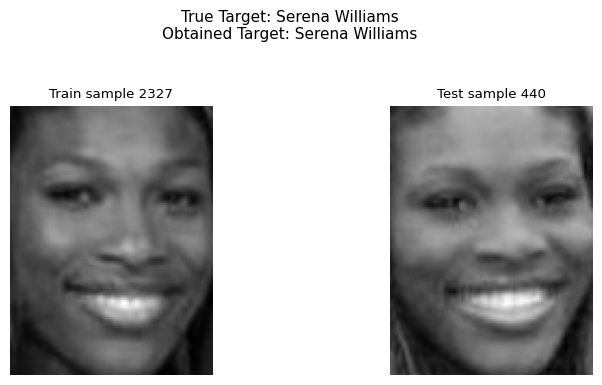



___________________________________________________________________________________




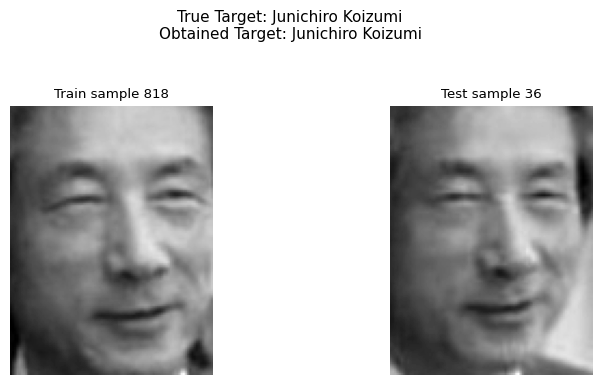



___________________________________________________________________________________




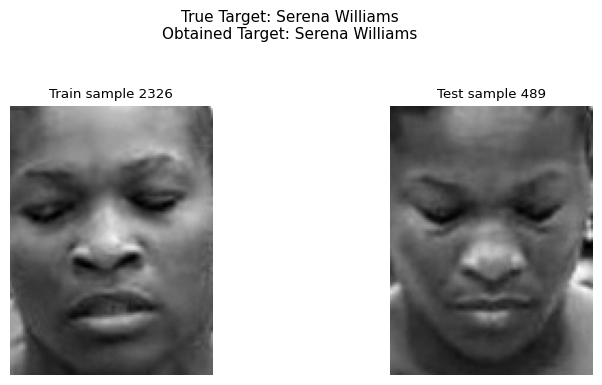



___________________________________________________________________________________




In [85]:
#plot and compare 10 of the top most similar images
plot_TrainVsTest(X_train, X_test, h, w, train_indx, test_indx, 10)


Indeed, in most of the cases reviewed, the face images of the same individuals were identified and matched correctly. However, the number of image similarities obtained is arguably modest still. It is very likely however that increasing the number of principal components would have led to more matches and better results overall. For now I will perform classification with the PCA-derived components and assess the results. This might well act as another testing trial: if the classification performance remains the same as the original, then we can deem the PCA model efficient for representing the data. 
<br><br>

**Classification with PCA**
<br>
Now we can use the obtained principal components to train a logistic regression classifier to identify and classify the face images

In [86]:
#Create logistic regression object
LR = LogisticRegression(solver='lbfgs', random_state=rs, n_jobs=-1)

#fit the LR classifier with the PCA data
LR_model = LR.fit(X_train_pca, y_train)

#get class peridctions 
y_pred = LR_model.predict(X_test_pca)

#Report overall classification error results 
print('Classification error scores (weighted average):')
error_scores(y_test, y_pred)


Classification error scores (weighted average):


Error score
Accuracy          0.72
Recall            0.72
Precision         0.74
F1 score          0.72

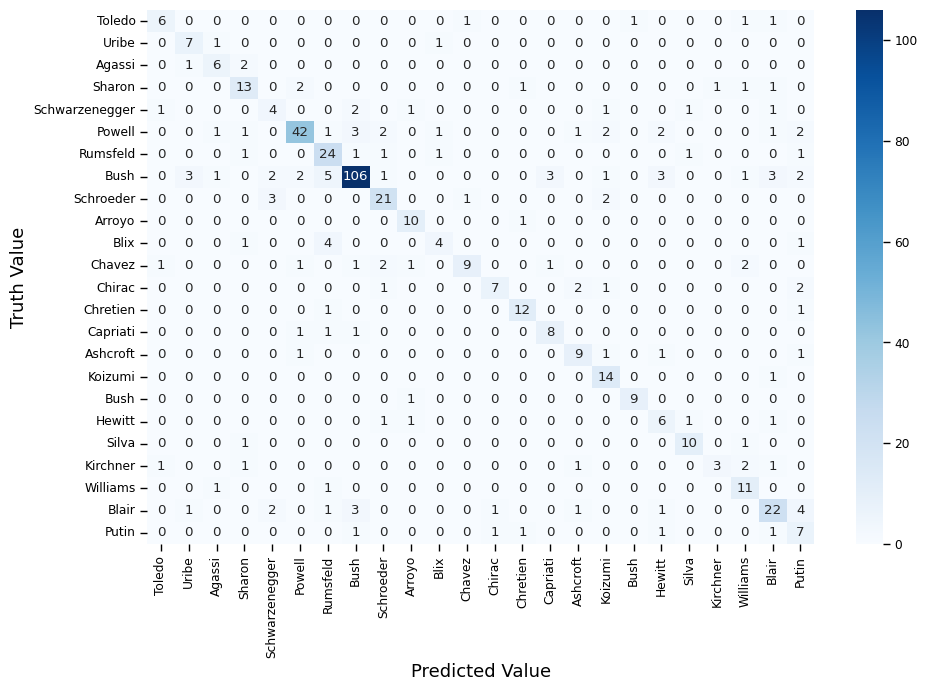

In [87]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, names=[name.split(' ')[-1] for name in names])


As demonstrated here, our classification performance with the PCA data is almost identical to the performance of the baseline model, obtaining an accuracy and f1 score of 0.72 each. Thus, we have managed to attain the same classification results, however with a much smaller number of features, only 468 features relative to the original number of 11,750 features! This is in fact a good feat considering that we could achieve the same exact performance with only a fraction of the features (around 4% of the original number). Next, I will test out different dimensionality reduction techniques to determine whether we can find a better one or obtain similar results with a lower number of features overall. As such, I will move next to Multi-dimensional scaling for dimensionality reduction, evaluate it again for the task and then run the logistic regression classifier once more. 
<br><br>

#### Model Two: Multi-Dimensional Scaling

Multi-Dimensional Scaling (MDS) is a non-linear dimensionality reduction technique that again aims to reduce the number of features in the data, but instead of focusing on variance and the preservation of variance in the data, it focuses on distances between the data and aims to preserve these distances instead when projecting the data to a lower-dimensional feature space. 
<br>

In [88]:
#Compute the cosine distance matrices
cosine_dist_train = cosine_distances(X_train_std)
cosine_dist_test = cosine_distances(X_test_std)


In [89]:
#In order to identify the most optimal number of dimensions, I will test out different n_components values and measure 
# the reduction in reconstruction error using the stress metric
#Define number of components to test out 
n_components_lst = [10, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]

#create empty list to store results
stress_scores = []

#iterate over n components and get stress score to find the better one
for i,n_comp in enumerate(n_components_lst):
        #Create mds object and set dim reduction characteristics
        mds = MDS(n_components=n_comp, metric=False, normalized_stress=False, dissimilarity='precomputed', random_state=rs, n_jobs=-1)
        
        #Fit cosine matrix data 
        mds.fit(cosine_dist_train)

        #compute and store stress score 
        stress_scores.append(round(mds.stress_,3))
        print(f'{i+1}/{len(n_components_lst)} runs completed')

#Report results
stress_scores_df = pd.DataFrame({'n_components': n_components_lst, 'stress score': stress_scores}).set_index('n_components')
stress_scores_df


1/14 runs completed
2/14 runs completed
3/14 runs completed
4/14 runs completed
5/14 runs completed
6/14 runs completed
7/14 runs completed
8/14 runs completed
9/14 runs completed
10/14 runs completed
11/14 runs completed
12/14 runs completed
13/14 runs completed
14/14 runs completed


stress score
n_components              
10               21135.364
25                7763.252
50                3743.171
100               1839.058
150               1223.087
200                917.559
250                732.663
300                610.903
350                526.243
400                460.916
450                409.907
500                370.056
550                336.698
600                308.948

<Axes: title={'center': 'Stress Scores and Number of Components'}, xlabel='n_components', ylabel='stress score'>

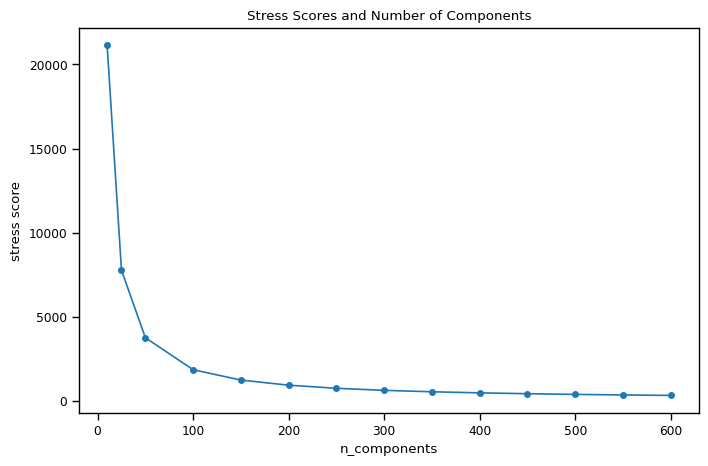

In [90]:
#Plotting out the stress scores across the different dimensions 
stress_scores_df.plot(figsize=(8,5), marker='o', markersize=4, 
                    title='Stress Scores and Number of Components',
                    xlabel='n_components', ylabel='stress score', legend=False)


As seen, judging by the both graph and the table of results, the most optimal number of components seem to be about 200 dimensions; performance appears to stabilize with little improvements after that. Hence, I will create a MDS model with 200 components and then evaluate it further.


**Final Model Selection**

In [99]:
#Create MDS model with the best number of components obtained
n_components = 200
mds = MDS(n_components=n_components, metric=False, dissimilarity='precomputed', random_state=rs, n_jobs=-1)

#Fit and transform the data
X_train_mds = mds.fit_transform(cosine_dist_train)
X_test_mds = mds.fit_transform(cosine_dist_test)


**Model Evaluation**

**Testing the Model: Testing Model Generalizability**
<br>
We can once again test for the model generalizability here by computing the cosine pairwise distances between the training  and testing set, and then examine the most similar cases across both sets more closely


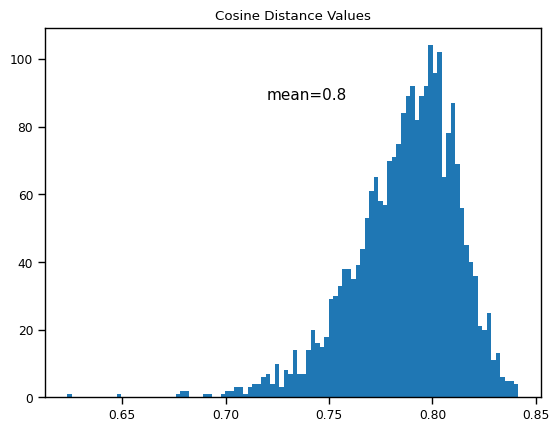

In [100]:
#Get pairwise cosine distances
cos_distances_mtrx = cosine_distances(X_train_mds, X_test_mds)

#Get column indices with most distance similarity and their corresponding cosine distance values (sorted in ascending order)
min_dist_indices = np.argmin(cos_distances_mtrx, axis=1)
min_cosine_dist = np.min(cos_distances_mtrx, axis=1)

#Now visualize the distribution of the distance values using a histogram
plt.hist(min_cosine_dist, bins=100)
plt.title('Cosine Distance Values')
plt.annotate(text=f'mean={np.mean(min_cosine_dist):.1f}', xy=(0.72,88), fontsize=11)
plt.show()


The distribution of cosine distances here is much different from the one observed earlier, with most distance scores this time around falling between ~0.73 and ~0.83, and skewed to the right with a mean of 0.8. Thus, we find little to no pairwise distances within the lower end as before. This indicates that the model is doesn't assume or is unable to accurately identify many similarities between the data, and is likely inappropriate for our current dataset altogether. To take a closer look, I will examine the image similarities in the lower end of the distribution here.


**Testing the Model: Facial Recognition Performance**
<br>
I will once again look at the cosine distance similarities identified at the lower end of the resulting distribution here. In contrast to PCA, there's virtually no pairwise distance scores in the extreme lower end of around 0.1, hence I will adjust the range as appropriate to the current distribution, setting the threshold between 0.6 to 0.7. I will then obtain the paired images within that range, plot and compare them to determine the model's facial recognition performance

In [101]:
#Get indices for images that are most similar with their pairwise distances falling between 0.6 and 0.7
train_indx, test_indx = get_threshold(min_cosine_dist, min_dist_indices, min_cos=0.6, max_cos=0.7)

#check the resulting shape
train_indx.shape, test_indx.shape


((10,), (10,))

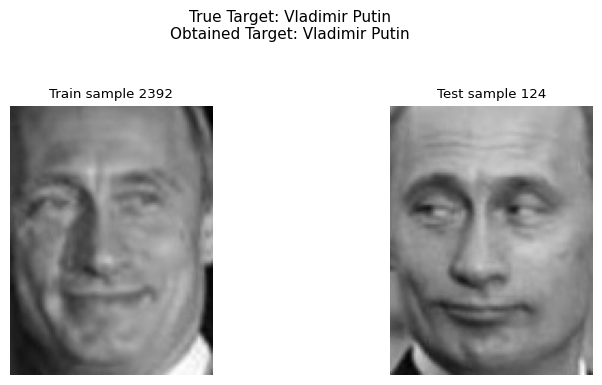



___________________________________________________________________________________




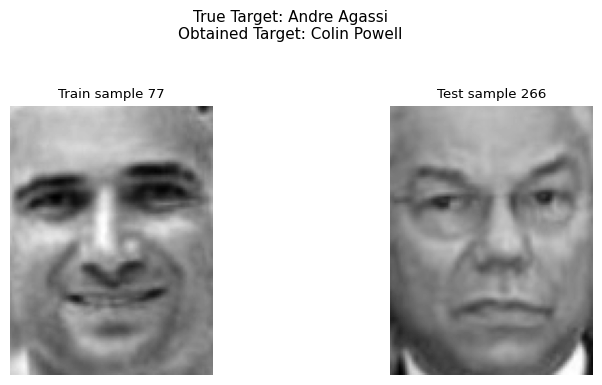



___________________________________________________________________________________




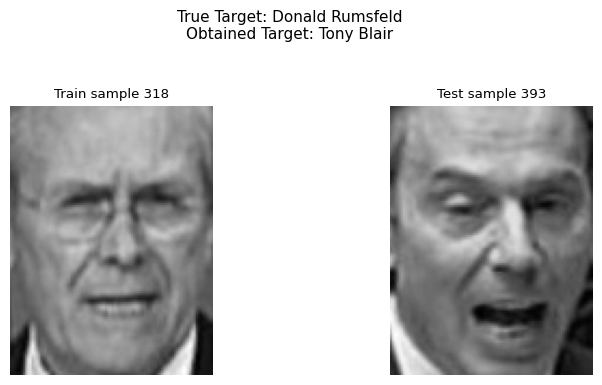



___________________________________________________________________________________




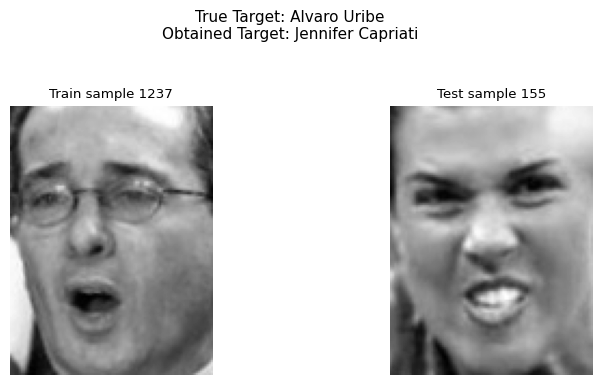



___________________________________________________________________________________




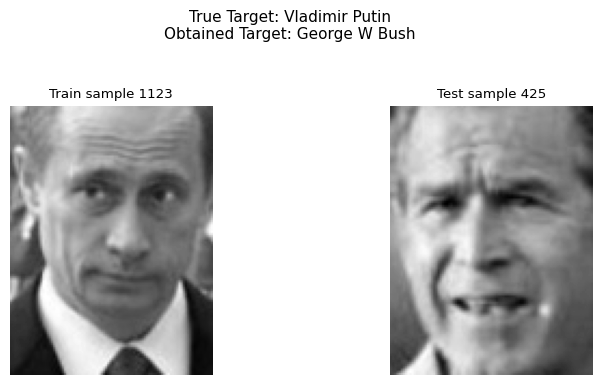



___________________________________________________________________________________




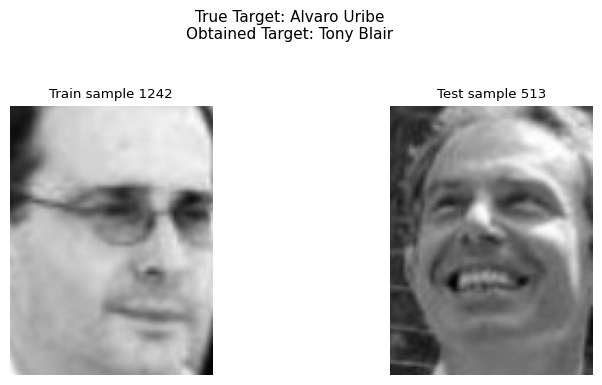



___________________________________________________________________________________




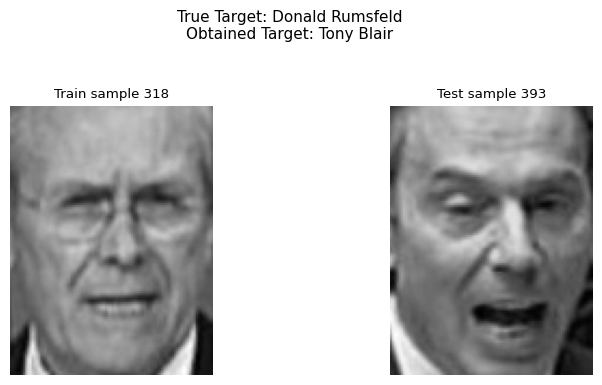



___________________________________________________________________________________




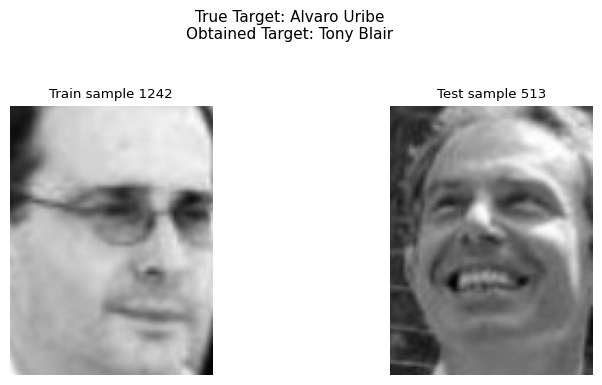



___________________________________________________________________________________




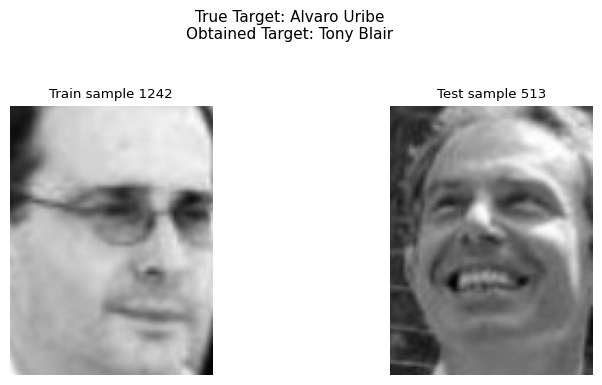



___________________________________________________________________________________




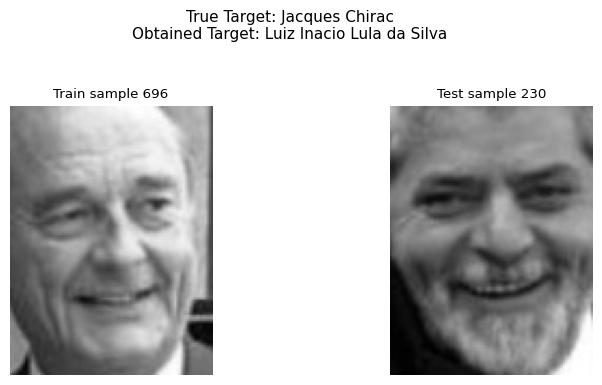



___________________________________________________________________________________




In [102]:
#plot and compare the 10 matches obtained
plot_TrainVsTest(X_train, X_test, h, w, train_indx, test_indx, 10)


As observed here we have obtained 10 matches within the range of 0.6-0.7, and almost none of them were correctly paired. Thus, we can confidently discard this model as inappropriate for the data. Indeed, MDS is generally not recommended for image-type data. Now for further proof, we can once again run a classification algorithm with the MDS-transformed data and evaluate the results.
<br>
<br>

**Classification with MDS**

In [103]:
#Create logistic regression object 
LR = LogisticRegression(solver='lbfgs', random_state=rs, n_jobs=-1)

#fit the LR classifier with the MDS data 
LR_model = LR.fit(X_train_mds, y_train)

#get class peridctions 
y_pred = LR_model.predict(X_test_mds)

#Report overall classification error results 
print('Classification error scores (weighted average):')
error_scores(y_test, y_pred)


Classification error scores (weighted average):


Error score
Accuracy          0.04
Recall            0.04
Precision         0.10
F1 score          0.05

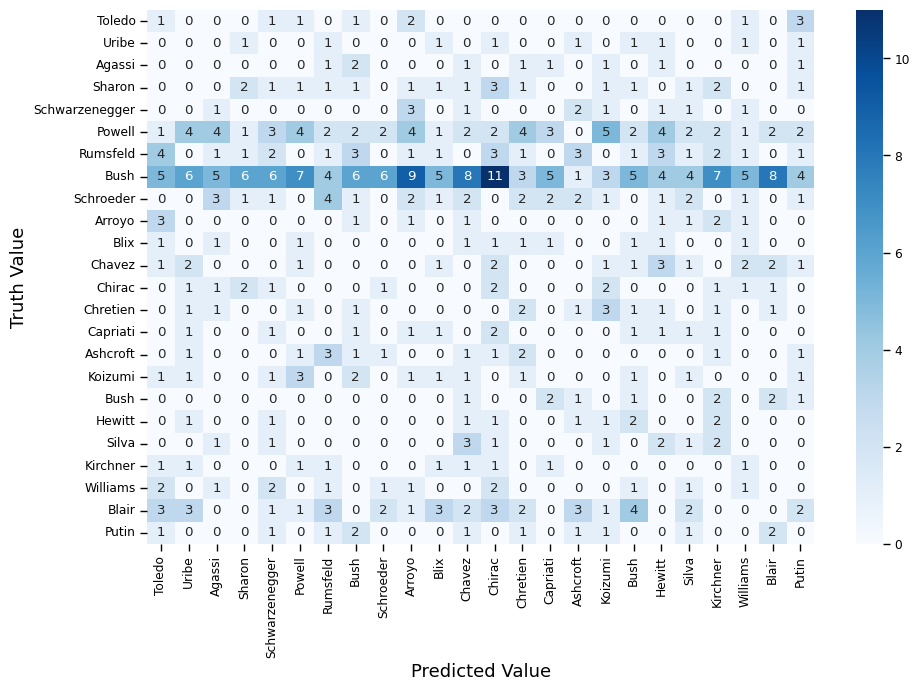

In [104]:
#visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, names=[name.split(' ')[-1] for name in names])


Indeed, the classification performance scores are very low, with an accuracy of only 0.04 and an average F1 score of 0.05! This further proves that the MDS model is not good for the data in the least. Now I will move to the third and final dimensionality reduction technique to be considered: non-negative matrix factorization.


#### Model Three: Non-Negative Matrix Factorization

Non-Negative Matrix Factorization (NMF) is another popular dimensionality reduction technique best suited for data with non-negative values. NMF reduces the number of dimensions of the data by decomposing the original data matrix into two smaller matrices, a basis matrix (H) and a coefficient matrix (W), which basically extract out the most essential elements in the data and assign weights to each of them, respectively. If the data are represented by the basis components and weights correctly, then the dot product of the two factor matrices yields a close approximation of the original, higher-dimensional data in a lower dimensional space. <br>
Now the task here is to identify the most appropriate number of basis components by which to represent the data with a lower number of features overall. As such, I will loop through different values for the n_components parameter to test out the reconstruction quality with different number of components. Particularly, I will employ Frobenius norm to estimate the reconstruction quality, comparing the image before and after dimensionality reduction. The lower the resulting error, the better the NMF model's performance as it means in can account for the data better.
<br>

In [105]:
#Define the parameter values to traverse through
n_components_lst = [10, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]

#Create empty lists to store results 
reconstruction_errors = []

#loop over n_components_lst and return frobenius error score
for i,n_component in enumerate(n_components_lst):
    #Create NMF object and set parameters
    nmf = NMF(n_components=n_component, init='nndsvd', max_iter=500, random_state=rs)

    #Fit the data
    nmf.fit(X_train)

    #compute and store reconstruction error and corresponding parameters
    reconstruction_errors.append(round(nmf.reconstruction_err_,3))
    print(f"{i+1}/{len(n_components_lst)} runs completed")

#organize and report results
results_table = pd.DataFrame({'n_components': n_components_lst, 'error score': reconstruction_errors}).set_index('n_components')
results_table


1/14 runs completed
2/14 runs completed
3/14 runs completed
4/14 runs completed
5/14 runs completed
6/14 runs completed
7/14 runs completed
8/14 runs completed
9/14 runs completed
10/14 runs completed
11/14 runs completed
12/14 runs completed
13/14 runs completed
14/14 runs completed


error score
n_components             
10                531.347
25                435.864
50                365.982
100               293.178
150               249.499
200               219.234
250               196.604
300               178.280
350               162.755
400               149.108
450               137.615
500               127.087
550               118.376
600               109.705

<Axes: title={'center': 'Reconstruction Error and Number of Components'}, xlabel='Number of Components', ylabel='Reconstruction Error (Frobenius Norm)'>

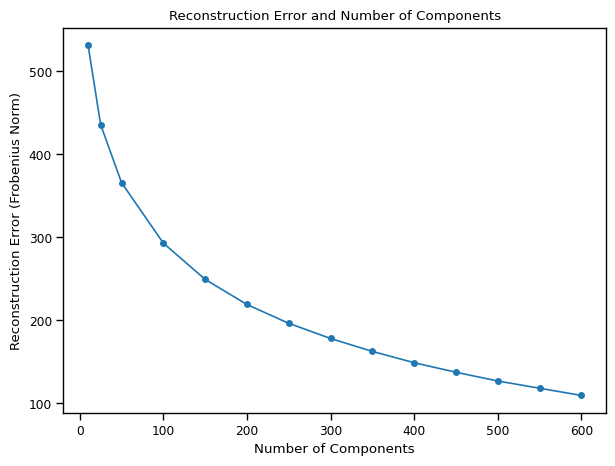

In [106]:
#visualize the results 
results_table['error score'].plot(figsize=(7,5), marker='o', markersize=4, 
                        title='Reconstruction Error and Number of Components', 
                        xlabel='Number of Components', ylabel='Reconstruction Error (Frobenius Norm)') 


We can see in the graph above that the the image reconstruction error (Frobenius norm) is higher with lower components and gradually decreases as the number of components increase. However, based off the graph as well as the results table, it seems to stabilize more around 400 dimensions, decreasing at a slightly slower rate than prior, which indicates that 400 dimensions seem to be the optimal number of components here for representing the original data in a lower dimensional space. Thus, I will develop the final NMF model with 400 dimensions and transform the data to represent it in this lower dimensional feature space of only 400 dimensions.

**Final Model Selection**

In [107]:
#Developing an NMF model with the most optimal n_components obtained
#assign the number of components
n_components = 400
#create NMF object and set relevant parameters
NMF_best = NMF(n_components=n_components,init='nndsvd', max_iter=500, random_state=rs)
#transform the train and test data to get the factor matrices
W_train = NMF_best.fit_transform(X_train)
W_test = NMF_best.transform(X_test)
H_mtrx = NMF_best.components_


**Model Evaluation**

**Testing the Model: Assessing image reconstruction quality** 
<br>
As per usual, first I will begin by testing the model's performance by assessing the reconstruction quality, measuring  the similarity between the original testing data (X_test) and the data approximated by the model (X_test_inv)


Mean cosine distance score (X vs. X_inv): 0.004



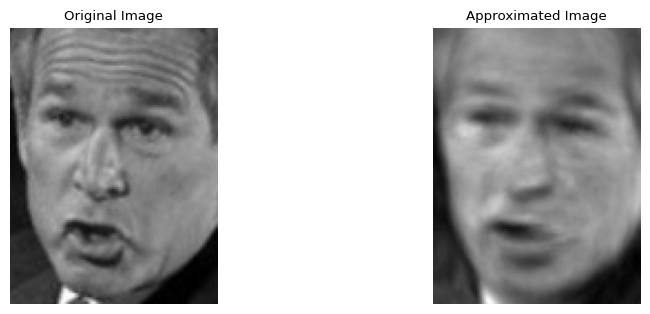



_____________________________________________________________________________________________




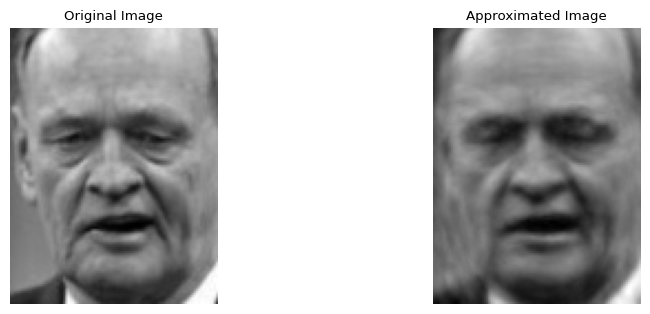



_____________________________________________________________________________________________




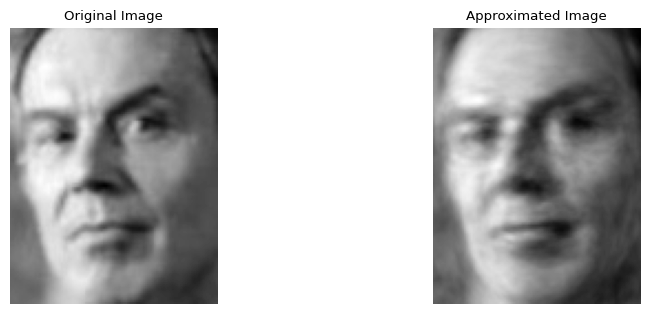



_____________________________________________________________________________________________




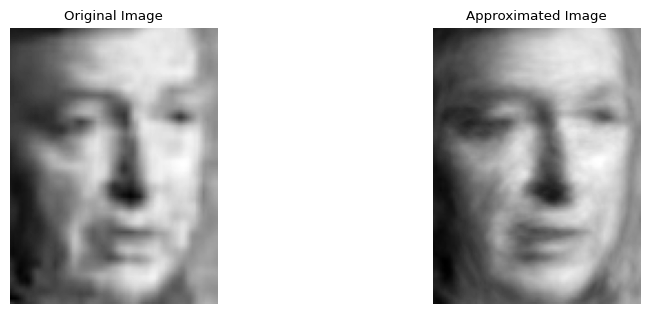



_____________________________________________________________________________________________




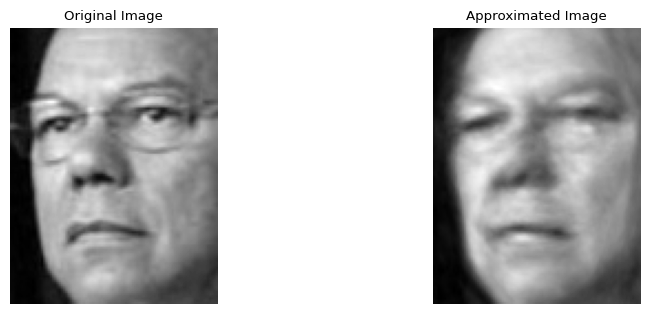



_____________________________________________________________________________________________




In [108]:
#Get the data approximate using the tuned NMF model
X_test_inv = np.dot(W_test,H_mtrx)

#get cosine distances between original data and NMF-approximated data
cos_distances = cosine_distances(X_test, X_test_inv)

#get diagonal pairwise distances for direct one-to-one comparisons
diagonal_mtrx = np.diagonal(cos_distances)

#compute and report the mean cosine distance
mean_cos_distance = np.mean(diagonal_mtrx)
print('Mean cosine distance score (X vs. X_inv):', round(mean_cos_distance,3))
print()

#We can assess reconstruction quality by looking at some of the images before and after NMF approximation
#evaluate NMF reconstruction quality of selected images 
for face_indx in random_face_generator(X):  
    evaluate_reconstruction(X, NMF_best, face_indx)


As demonstrated, the mean cosine score is 0.004, which is indicative of pretty high similarity as the closer the cosine score is to 0, the greater the similarity between the data compared. And looking at the reconstructed images, we can see that they're generally similar to the originals and distinguishable to a good degree. Now what needs to be determined is whether the NMF model is better for representing the data and whether it can account for all the varieties in it. Now I'll proceed to test for model generalizability and facial recognition performance before deciding between the NMF model and the PCA model obtained earlier.

<br>

**Testing the Model: Testing Model Generalizability** 
<br>
As a second testing procedure, I will examine the model's generalizability by comparing the coefficient matrices of the training set and the testing set. Higher similarities between the two matrices should indicate better model generalizability

In [109]:
#Get cosine distance between the two coefficient matrices
W_cos_distances = cosine_distances(W_train, W_test)

#get diagonal pairwise distances for one-to-one comparisons
W_diagonal_mtrx = np.diagonal(W_cos_distances)

#compute and report the mean cosine distance
W_mean_cos_distance = np.mean(W_diagonal_mtrx)
print('Mean cosine distance score (W_train vs. W_test):', round(W_mean_cos_distance,3))


Mean cosine distance score (W_train vs. W_test): 0.437


We can also look directly at the distribution of cosine distances capturing the distance between the coefficient matrices of the training and testing data


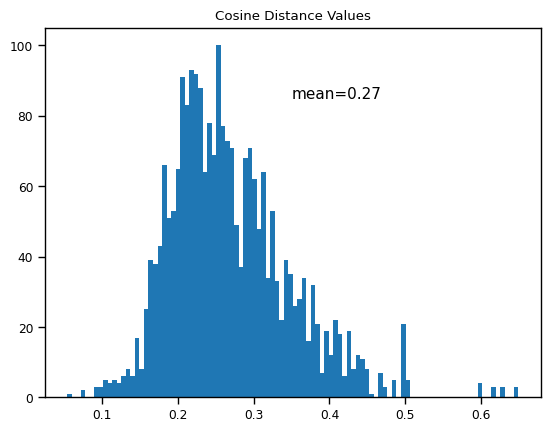

In [110]:
#Get column indices with most distance similarity and their corresponding cosine distance values (sorted in ascending order)
min_dist_indices, min_cosine_dist = np.argmin(W_cos_distances, axis=1), np.min(W_cos_distances, axis=1)

#Now visualize the distribution of the distance values using a histogram
plt.hist(min_cosine_dist, bins=100)
plt.title('Cosine Distance Values')
plt.annotate(text=f'mean={np.mean(min_cosine_dist):.2f}', xy=(0.35,85), fontsize=11)
plt.show()


As shown in the figure above, the distribution of minimum cosine distances fall between ~0.15 and ~0.45, with a mean cosine distance of 0.27. This indicates a fairly good amount of similarity, much like the distances distribution obtained with the PCA model prior. Nonetheless, in order to discern whether the obtained similarities are actual or merely assumed by the model based on its latent components is yet to be verified. To verify, we can once again set the similarity threshold according to our current distribution and determine how many similarity or almost identical cases we can obtain.
<br><br>

**Testing the Model: Facial Recognition Performance**
<br>
Lastly, as just mentioned, I will test the NMF model further by examining its capacity for performing facial recognition. If the original data are represented correctly in the lower dimensional space then we should expect good facial recognition performances when comparing face images from the training and testing sets. Now, consistent with the above distribution, I will set the similarity range between a minimum cosine distance of 0 and a maximum cosine distance of 0.15 which represent the lower extreme in terms of highest similarity. The obtained similarity cases will once again be plotted out for comparison


In [111]:
#Get indices for images that are most identical, with their pairwise distances falling between 0 and 0.005
train_indx, test_indx = get_threshold(min_cosine_dist, min_dist_indices, min_cos=0, max_cos=0.15)

#check the resulting shape
train_indx.shape, test_indx.shape


((66,), (66,))

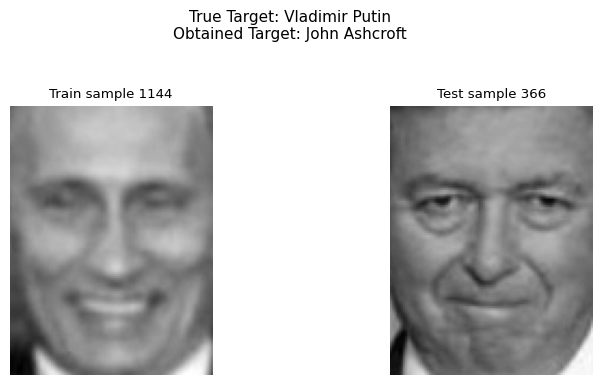



___________________________________________________________________________________




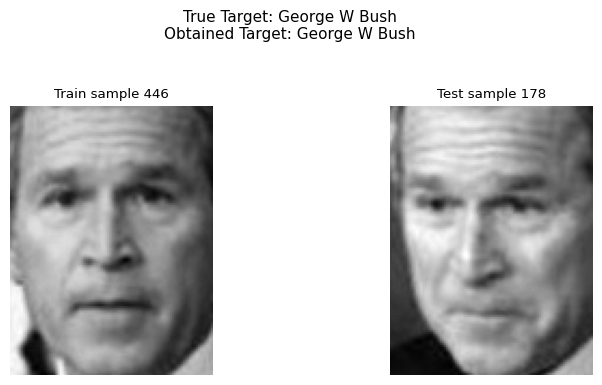



___________________________________________________________________________________




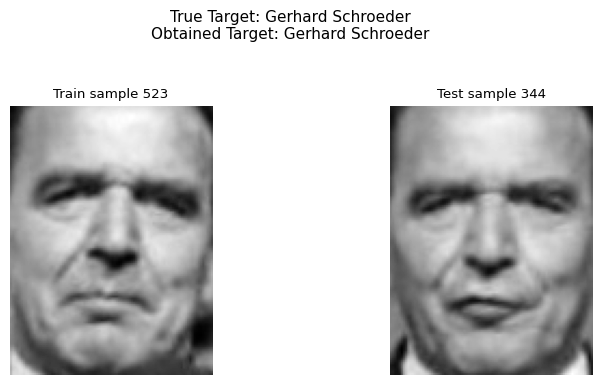



___________________________________________________________________________________




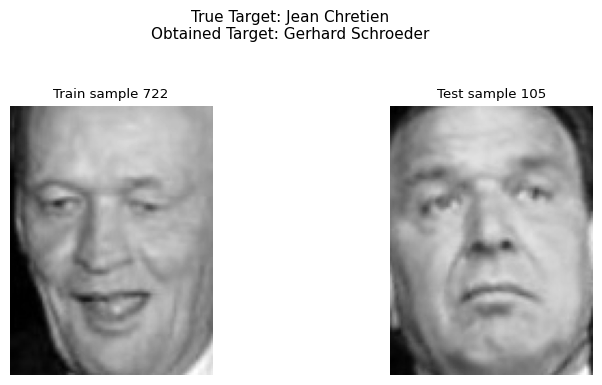



___________________________________________________________________________________




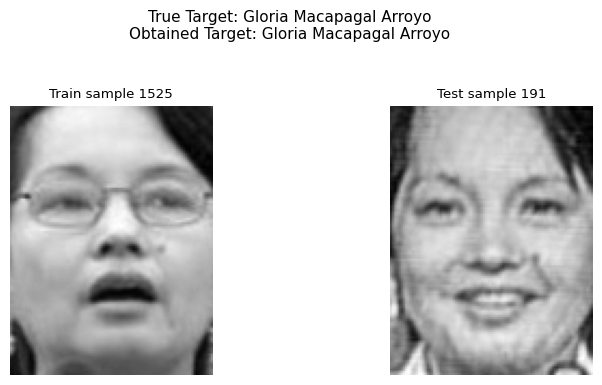



___________________________________________________________________________________




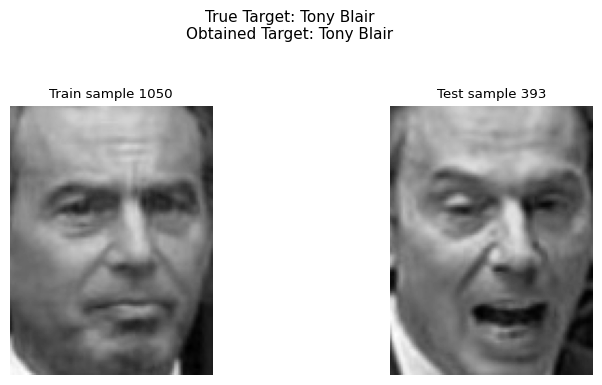



___________________________________________________________________________________




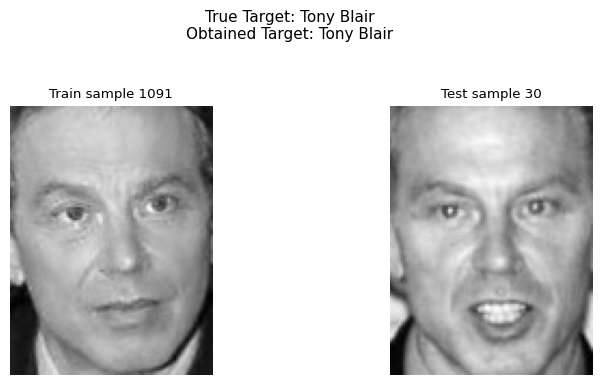



___________________________________________________________________________________




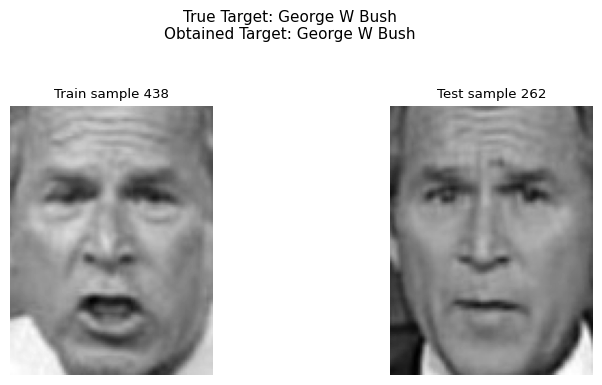



___________________________________________________________________________________




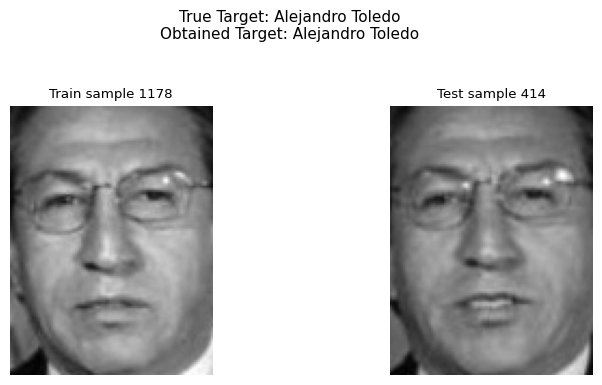



___________________________________________________________________________________




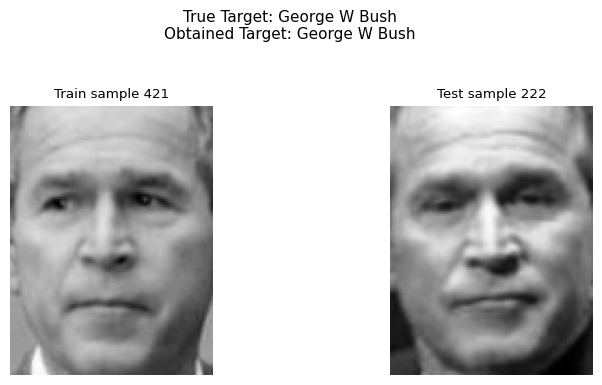



___________________________________________________________________________________




In [112]:
#Plot and compare 10 of the top most similar images 
plot_TrainVsTest(X_train, X_test, h, w, train_indx, test_indx, 10)


As demonstrated here, the model indeed seems to be performing a fairly good job representing the data, getting most of the cases reviewed here correctly. Thus, the obtained NMF model appears to be strong contender to the PCA one obtained earlier. Now, as a final testing procedure, I will once again perform logistic regression with the NMF data obtained and assess the resulting classification performance before deciding on which dimensionality technique is most appropriate for the data. If the classification performance remains the same as the original, then we can deem NMF as the best dimensionality reduction technique for our current case. If however performance is lowered, then the PCA model would arguably be the better one as it would be representing the data better more accurately and thus is more suited for our task.
<br><br>

**Classification with NMF**

In [113]:
#Create logistic regression object 
LR = LogisticRegression(solver='lbfgs', random_state=rs, n_jobs=-1)

#fit the LR classifier with the MDS data 
LR_model = LR.fit(W_train, y_train)

#get class peridctions 
y_pred = LR_model.predict(W_test)

#Report overall classification error results 
print('Classification error scores (weighted average):')
error_scores(y_test, y_pred)


Classification error scores (weighted average):


Error score
Accuracy          0.61
Recall            0.61
Precision         0.64
F1 score          0.61

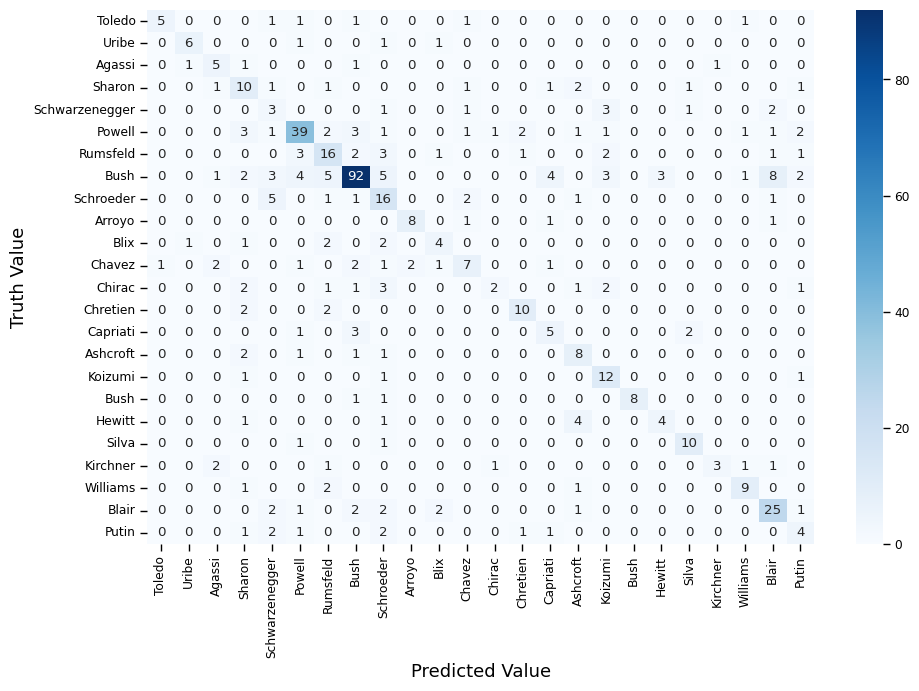

In [114]:
#visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, names=[name.split(' ')[-1] for name in names])


Indeed, as demonstrated by the evaluation results, the classification performance was lower with the NMF transformed data, falling down from a baseline accuracy score of 0.71 (and baseline F1 score of 0.72) to an accuracy score of 0.61 (and F1 score of 0.61). As such, we can conclude that PCA is better dimensionality reduction technique for representing and transforming the data, as demonstrated by each of the evaluation measures considered as well as, and most importantly here, by the classification performance using the transformed data. Now our task on discerning the best dimensionality reduction technique is complete, next I will move to deciding the final and best performing classification model for the data. Thus far, we have only considered logistic regression for the classification task, however it is possible that other classifiers might be better able to perform the task, or else performance might improve with further hyperparameter tuning. This will be the concern of the next section. 
<br><br>

## Part Four: Classification - Model Comparison and Selection 
<br>
In this section, I will consider each of three classification models: Logistic Regression, Support Vector Machine, and K-Nearest Neighbors. I will once again use the data derived from the PCA model and pass it to each of the three classifiers, perform hyperparameter tuning on each, and then compare and contrast their performances in order to identify the best performing model.
<br>
<br>

In [115]:
#Define estimators to test 
estimators = [('LR', LogisticRegression(solver='lbfgs', random_state=rs, n_jobs=-1)), 
              ('SVC', SVC(kernel='rbf', random_state=rs)), 
              ('KNN', KNeighborsClassifier(metric='cosine', n_jobs=-1)) ]


#Define parameters for grid search with each 
#parameters for the logistic regression model 
params_LR = { 'penalty': [None, 'l2'], 'C': np.geomspace(0.00001,100,8) }
#parameters for the SVC model 
params_SVC = {'C': np.geomspace(0.0001,10,6) } 
#parameters for the KNN model 
params_KNN = { 'n_neighbors': np.arange(1,11), 'weights': ['uniform', 'distance'] }

#Create a list with the parameters 
estimators_params = [params_LR,  params_SVC, params_KNN]


In [116]:
#Create empty lists to store result 
error_results = []
best_estimators = []
best_params = []

#Now iterating over the different models and applying different resampling techniques to find the best combinations
for estimator, params in zip(estimators, estimators_params):
    #create grid search object 
    grid = GridSearchCV(estimator=estimator[1], param_grid=params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
    #fitting and tuning classifier 
    grid.fit(X_train_pca, y_train)
    #get best estimator 
    best_estimator = grid.best_estimator_
    #generate class predictions
    y_pred = best_estimator.predict(X_test_pca)
    #get error scores and store them
    error_dict = error_scores_dict(y_test, y_pred, model=estimator[0])
    error_results.append(error_dict)
    best_estimators.append((estimator[0], best_estimator))

#Report error scores 
error_table = pd.DataFrame(error_results).set_index('Model')
error_table


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


Accuracy  Precision  Recall  F1 Score
Model                                       
LR         0.73       0.75    0.73      0.74
SVC        0.69       0.71    0.69      0.68
KNN        0.39       0.43    0.39      0.39

In [117]:
#Report the best estimator 
print('Best estimator (and parameters):\n\n', best_estimators[np.argmax(error_table['Accuracy'])][1])


Best estimator (and parameters):

 LogisticRegression(C=0.01, n_jobs=-1, random_state=222)


       Accuracy  Precision  Recall  F1 Score
Model                                       
LR         0.73       0.75    0.73      0.74
SVC        0.69       0.71    0.69      0.68
KNN        0.39       0.43    0.39      0.39





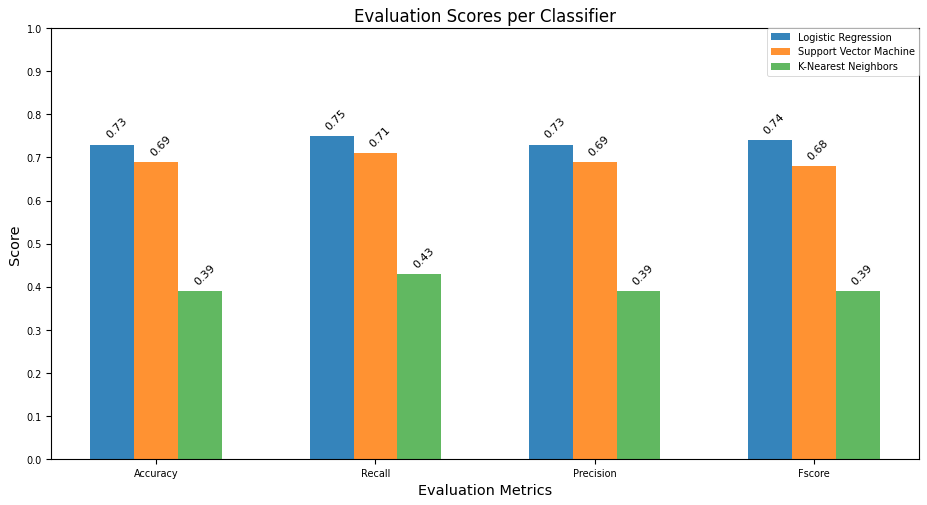

In [118]:
#Finally, I will plot the grid search results to compare the models' performances
#Visualize the evaluation results 
visualize_models_results(error_table) 


As depicted by the bar chart above, the best performing model remains the logistic regression classifier (with L2 penalty and C=0.01), averaging an accuracy score of 0.73 and F1 score of 0.74, followed by the support vector machine classifier, averaging an accuracy score of 0.69 and F1 score of 0.68, and coming last is the K-Nearest Neighbors classifier, averaging an accuracy and F1 scores of 0.39. Thus, we can finally conclude that the best dimensionality reduction technique for the current data is principal component analysis with 468 principal components and the best classification model is logistic regression. Indeed, the final classifier, with the PCA-derived data performed just the same as the baseline classifier with the original data in its entirety.
<br><br>

**Conclusion**
<br><br>
To sum up, consistent with the objectives of the project, three dimensionality reduction techniques were considered for representing a large image dataset in a lower-dimensional space, and importantly for facilitating classification of the targets' faces. Two of these techniques proved efficient for the task: PCA and NMF. Both techniques performed fairly well across all three evaluation procedures employed: producing a good image reconstruction quality when comparing images before and after dimensionality reduction; generating generalizable results when quantifying pairwise distances between two different sets; and demonstrating very good facial recognition performances when using pairwise distances to compare faces of different target individuals from two diferent sets. However, looking at the classification results using the data derived from each of these two techniques, the classification performance was better with the PCA-approximated data, attaining a near identical classification results as the baseline classifier trained with the entire, intact dataset. Thus, in conclusion, PCA proved to be the better dimensionality reduction technique for representing the original data in a lower-dimensional space, reducing the data by a great extent whilst also retaining the same performance as before reduction. Finally, to ensure the best classification performance, more classifiers were considered, optimized and evaluated. Of the three classifiers considered, logistic regression, support vector machine, and K-nearest neighbors, the logistic regression model emerged as the best performing one. 
<br>
<br>
